<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 1*

# Recurrent Neural Networks and Long Short Term Memory (LSTM)

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [ ]:
pip install keras

In [1]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

# from __future__ import print_function

import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Embedding, Dropout, SimpleRNN, LSTM
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import io
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd
import random
import sys
import os

Using TensorFlow backend.


#### At least 20 epochs are required before the generated text starts sounding coherent.

#### It is recommended to run this script on GPU, as recurrent networks are quite computationally intensive.

#### If you try this script on new data, make sure your corpus has at least ~100k characters. ~1M is better.

In [2]:
path = get_file(
    '100-0.txt',
    origin='https://www.gutenberg.org/files/100/100-0.txt')
with io.open(path, encoding='utf-8') as f:
    data = f.read().lower()
print('corpus length:', len(data))

corpus length: 5573152


In [3]:
text = data[500000:1000000]

In [4]:
import re

# text = re.sub(r'[^a-zA-Z ^0-9]', '', text)

In [5]:
text = re.sub("\\n", ' ', text)

In [6]:
len(text)

500000

In [7]:
text[0:500]

"  rosalind. why then, can one desire too much of a good thing? come,     sister, you shall be the priest, and marry us. give me your hand,     orlando. what do you say, sister?   orlando. pray thee, marry us.   celia. i cannot say the words.   rosalind. you must begin 'will you, orlando'-   celia. go to. will you, orlando, have to wife this rosalind?   orlando. i will.   rosalind. ay, but when?   orlando. why, now; as fast as she can marry us.   rosalind. then you must say 'i take thee, rosalind"

In [8]:
text = re.sub(r'[^a-zA-Z ^0-9]', '', text)

In [9]:
text[0:500]

'  rosalind why then can one desire too much of a good thing come     sister you shall be the priest and marry us give me your hand     orlando what do you say sister   orlando pray thee marry us   celia i cannot say the words   rosalind you must begin will you orlando   celia go to will you orlando have to wife this rosalind   orlando i will   rosalind ay but when   orlando why now as fast as she can marry us   rosalind then you must say i take thee rosalind for wife   orlando i take thee rosali'

In [10]:
len(text)

475227

In [ ]:
# f = open('/file_name.txt') # Open file on read mode
# lines = f.read().split("\n") # Create a list containing all lines
# f.close()

In [ ]:
# len(lines)

In [11]:
# Encode Data as Chars

# Gather all text 
# Why? 1. See all possible characters 2. For training / splitting later

text = " ".join(text)

# Unique Characters

# chars = list(set(text))
chars = sorted(list(set(text)))

print('total chars:', len(chars))
char_int = dict((c, i) for i, c in enumerate(chars))
int_char = dict((i, c) for i, c in enumerate(chars))

total chars: 27


In [12]:
chars

[' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [13]:
# cut the text in semi-redundant sentences of maxlen characters
# Create the sequence data
maxlen = 40
step = 5

encoded = [char_int[c] for c in text]

sentences = [] # Each element is 40 chars long
next_chars = [] # One element for each sequence

for i in range(0, len(encoded) - maxlen, step):
    
    sentences.append(encoded[i: i + maxlen])
    next_chars.append(encoded[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 190083


In [14]:
sentences[0]

[0,
 0,
 0,
 0,
 18,
 0,
 15,
 0,
 19,
 0,
 1,
 0,
 12,
 0,
 9,
 0,
 14,
 0,
 4,
 0,
 0,
 0,
 23,
 0,
 8,
 0,
 25,
 0,
 0,
 0,
 20,
 0,
 8,
 0,
 5,
 0,
 14,
 0,
 0,
 0]

In [15]:
# Create x & y
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char] = 1
        
    y[i, next_chars[i]] = 1

Vectorization...


In [16]:
x.shape

(190083, 40, 27)

In [17]:
y.shape

(190083, 27)

In [18]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               79872     
_________________________________________________________________
dense (Dense)                (None, 27)                3483      
Total params: 83,355
Trainable params: 83,355
Non-trainable params: 0
_________________________________________________________________


In [19]:
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [20]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(50):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [21]:
# fit the model
history = model.fit(x, y,
          batch_size=32,
          epochs=25,
          callbacks=[print_callback])

Train on 190083 samples
Epoch 1/25
190080/190083 [============================>.] - ETA: 0s - loss: 1.1535 - accuracy: 0.6667
----- Generating text after Epoch: 0
----- Generating with seed: "e y i n g   g u s t s   w e   h a v e   "
e y i n g   g u s t s   w e   h a v e   h i u s   s e p h e   e b e   h a v e   i   m e   
190083/190083 [==============================] - 233s 1ms/sample - loss: 1.1535 - accuracy: 0.6666
Epoch 2/25
190080/190083 [============================>.] - ETA: 0s - loss: 0.9618 - accuracy: 0.7111
----- Generating text after Epoch: 1
----- Generating with seed: " y o u r   r i n g   w h i c h   i n   m"
 y o u r   r i n g   w h i c h   i n   m y   c o r d o r   c a c e   y o u           l i t
190083/190083 [==============================] - 212s 1ms/sample - loss: 0.9619 - accuracy: 0.7111
Epoch 3/25
190048/190083 [============================>.] - ETA: 0s - loss: 0.8895 - accuracy: 0.7326
----- Generating text after Epoch: 2
----- Generating with seed: "        

190048/190083 [============================>.] - ETA: 0s - loss: 0.6233 - accuracy: 0.8034
----- Generating text after Epoch: 20
----- Generating with seed: "h e r   l i p s   i n   o p e n i n g   "
h e r   l i p s   i n   o p e n i n g   l i k e   a   p o s t h u m u s   c o n s w h a t 
190083/190083 [==============================] - 258s 1ms/sample - loss: 0.6232 - accuracy: 0.8034
Epoch 22/25
190080/190083 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.8054
----- Generating text after Epoch: 21
----- Generating with seed: "  b r o t h e r   d o   n o t   a s   s "
  b r o t h e r   d o   n o t   a s   s a i d   a r m y   y o u   s u c h   e v e n   h i 
190083/190083 [==============================] - 218s 1ms/sample - loss: 0.6176 - accuracy: 0.8054
Epoch 23/25
190080/190083 [============================>.] - ETA: 0s - loss: 0.6139 - accuracy: 0.8061
----- Generating text after Epoch: 22
----- Generating with seed: "  a n d   d e w s   o f   b l o o d   

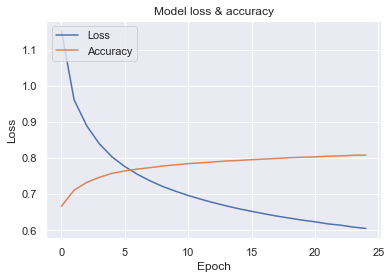

In [25]:
# Plot training loss and accuracyloss values
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show();

# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN